In [26]:
import pandas as pd
import numpy as np
import optuna
import warnings
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [27]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [28]:
X_train = pd.read_csv('model_variables/X_train_top.csv')
X_test = pd.read_csv('model_variables/X_test_top.csv')

y_train = pd.read_csv('model_variables/y_train.csv')
y_test = pd.read_csv('model_variables/y_test.csv')

In [29]:
X_test.describe()

,species_mix_wheat_aestivum_lentil,density_n_ratio,plant_density,soil_water_capacity,density_error,nitrogen_residual,total_precipitation,n_amount,growing_days,stress_index,soil_ph,soil_awc,irrigation_amount,GDD,high_humidity_days,heat_stress_days,crop_season_winter
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.207547,0.232324,107.470606,-0.213773,-6.935054,42.813753,1496.559340,22.877358,192.075472,0.543627,7.234277,282.933788,4.471698,1987.586838,387.716981,51.433962,0.603774
std,0.407477,0.632622,86.832582,0.362459,22.978651,19.978424,135.828025,47.679226,59.347836,0.090240,0.935338,32.073880,17.449905,821.489859,124.727723,35.515260,0.491436
min,0.000000,0.000000,11.488340,-0.577789,-69.699367,19.000000,1255.580000,0.000000,102.000000,0.365735,5.500000,70.000000,0.000000,594.488304,273.000000,0.000000,0.000000
25%,0.000000,0.000000,33.083333,-0.521055,-16.064665,31.227477,1389.460000,0.000000,123.000000,0.459361,6.725000,291.500000,0.000000,1393.206566,293.000000,18.000000,0.000000
50%,0.000000,0.000000,94.100000,-0.374000,-3.484225,41.000000,1524.770000,0.000000,232.000000,0.562778,7.393333,291.500000,0.000000,2317.089548,337.000000,69.000000,1.000000
75%,0.000000,0.000000,144.032922,0.182000,2.471451,42.000000,1590.930000,0.000000,244.000000,0.620970,7.900000,291.500000,0.000000,2797.405279,450.000000,81.000000,1.000000
max,1.000000,4.337798,370.370370,0.349000,147.979798,100.323003,1791.720000,180.000000,256.000000,0.655984,8.460000,333.000000,105.000000,2940.977404,649.000000,93.000000,1.000000


In [30]:
X_train.describe()

,species_mix_wheat_aestivum_lentil,density_n_ratio,plant_density,soil_water_capacity,density_error,nitrogen_residual,total_precipitation,n_amount,growing_days,stress_index,soil_ph,soil_awc,irrigation_amount,GDD,high_humidity_days,heat_stress_days,crop_season_winter
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,0.271429,0.317363,115.822425,-0.225715,-8.382337,43.084290,1515.355071,22.697619,187.390476,0.539915,7.298143,286.060076,3.476190,1935.536962,377.428571,52.319048,0.552381
std,0.445227,0.760805,86.770207,0.368072,26.558723,20.198682,131.382543,43.268452,59.708679,0.090829,0.899589,26.496513,15.049224,773.839629,116.341474,34.097475,0.497842
min,0.000000,0.000000,10.288066,-0.577789,-83.838384,19.000000,1255.580000,0.000000,83.000000,0.365735,5.500000,70.000000,0.000000,594.488304,273.000000,0.000000,0.000000
25%,0.000000,0.000000,41.446208,-0.524000,-18.236532,31.227477,1447.720000,0.000000,123.000000,0.452234,6.800000,291.500000,0.000000,1393.206566,289.000000,15.000000,0.000000
50%,0.000000,0.000000,105.871389,-0.448500,-4.812983,41.000000,1538.940000,0.000000,231.000000,0.516487,7.700000,291.500000,0.000000,1726.333906,336.000000,63.000000,1.000000
75%,1.000000,0.156771,151.668785,0.239500,2.404040,42.000000,1590.930000,30.000000,244.000000,0.620970,7.900000,291.500000,0.000000,2715.599568,462.000000,81.000000,1.000000
max,1.000000,4.744318,409.090909,0.362050,246.969697,100.323003,2123.880000,140.000000,256.000000,0.758860,8.460000,333.000000,105.000000,2940.977404,649.000000,105.000000,1.000000


In [31]:
# we check for the dimensionality of the training and testing variables
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (420, 17)
y_train shape: (420, 1)
X_test shape: (106, 17)
y_test shape: (106, 1)


In [32]:
# merge the dataset to create a validation set
X = pd.concat([X_train, X_test], axis=0)
y = np.log1p(pd.concat([y_train, y_test], axis=0))

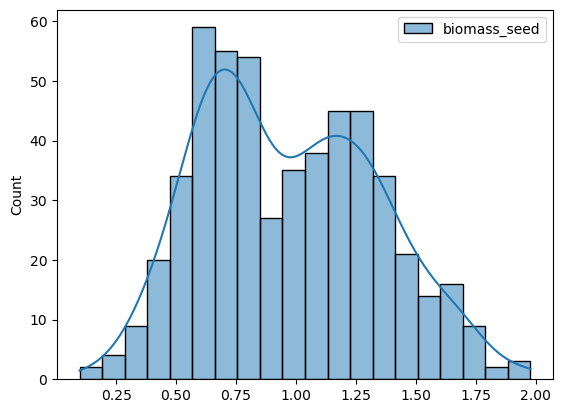

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y, bins=20, kde=True)
plt.show()

In [34]:
# Train 70%, Validation 15%, Test 15%

# train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
#train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

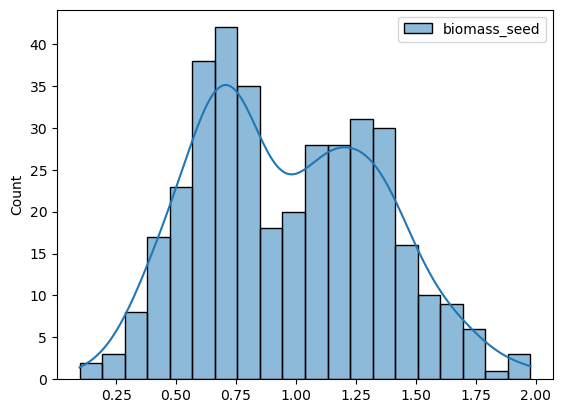

In [35]:
sns.histplot(y_train, bins=20, kde=True)
plt.show()

In [36]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 800, 1000, 1200]),  # Added more options
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Increased max depth range
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),  # Wider range
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Slightly wider range
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 5.0),  # Changed to loguniform
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),  # Wider range
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),  # New parameter
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),  # New parameter
    }
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    # Using 5-fold CV instead of 3-fold for more robust evaluation
    score = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return -score

In [37]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler,
    direction='minimize',
    study_name='xgb_tpe_opt'
)
study.optimize(objective, n_trials=100, timeout=600)

print("Best trial:", study.best_trial.params)

[I 2025-05-20 11:28:56,847] A new study created in memory with name: xgb_tpe_opt
[I 2025-05-20 11:28:57,281] Trial 0 finished with value: 0.29347230195999147 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1734451662584154, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'gamma': 0.0011916299962955155, 'reg_alpha': 7.072114131472227, 'reg_lambda': 1.452824663751602, 'min_child_weight': 2, 'colsample_bylevel': 0.5909124836035503}. Best is trial 0 with value: 0.29347230195999147.
[I 2025-05-20 11:28:58,020] Trial 1 finished with value: 0.2876977026462555 and parameters: {'n_estimators': 1200, 'max_depth': 4, 'learning_rate': 0.016536643976750174, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'gamma': 0.8023102291340046, 'reg_alpha': 0.0009962513222055108, 'reg_lambda': 0.03725393839578886, 'min_child_weight': 5, 'colsample_bylevel': 0.5232252063599989}. Best is trial 1 with value: 0.2876977026462555.
[I 2025-05-2

Best trial: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.025092557876503722, 'subsample': 0.9681813389671091, 'colsample_bytree': 0.9189038694956897, 'gamma': 0.0029143197332355173, 'reg_alpha': 0.00317929504532371, 'reg_lambda': 1.233909528803232, 'min_child_weight': 7, 'colsample_bylevel': 0.9556787811383483}


In [38]:
best_params = study.best_trial.params
final_model = XGBRegressor(**best_params, random_state=42)

# Cross-validate to check performance
cv_scores = cross_val_score(final_model, X_train, y_train, scoring='r2', cv=5)
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Cross-validation R² scores: [0.67754036 0.71591771 0.62575078 0.67804456 0.63552737]
Mean R²: 0.667 (+/- 0.065)


In [39]:
import matplotlib.pyplot as plt

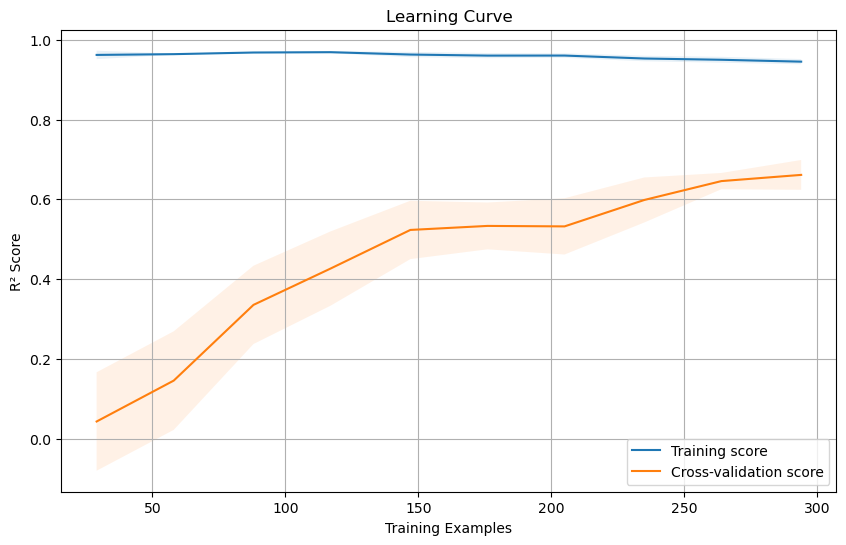

In [40]:
# Learning curve
def plot_learning_curve(model, X, y, cv=5):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, 
        train_sizes=train_sizes,
        scoring='r2'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std,
                     val_mean + val_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('R² Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curve
from sklearn.model_selection import learning_curve
plot_learning_curve(final_model, X_train, y_train)

In [41]:
final_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=True)

[0]	validation_0-rmse:0.33798
[1]	validation_0-rmse:0.33258
[2]	validation_0-rmse:0.32731
[3]	validation_0-rmse:0.32235
[4]	validation_0-rmse:0.31747
[5]	validation_0-rmse:0.31333
[6]	validation_0-rmse:0.30857
[7]	validation_0-rmse:0.30392
[8]	validation_0-rmse:0.29948
[9]	validation_0-rmse:0.29530
[10]	validation_0-rmse:0.29142
[11]	validation_0-rmse:0.28795
[12]	validation_0-rmse:0.28475
[13]	validation_0-rmse:0.28112
[14]	validation_0-rmse:0.27731
[15]	validation_0-rmse:0.27409
[16]	validation_0-rmse:0.27065
[17]	validation_0-rmse:0.26758
[18]	validation_0-rmse:0.26472


[19]	validation_0-rmse:0.26278
[20]	validation_0-rmse:0.26011
[21]	validation_0-rmse:0.25761
[22]	validation_0-rmse:0.25466
[23]	validation_0-rmse:0.25219
[24]	validation_0-rmse:0.25020
[25]	validation_0-rmse:0.24807
[26]	validation_0-rmse:0.24648
[27]	validation_0-rmse:0.24447
[28]	validation_0-rmse:0.24303
[29]	validation_0-rmse:0.24129
[30]	validation_0-rmse:0.23929
[31]	validation_0-rmse:0.23783
[32]	validation_0-rmse:0.23621
[33]	validation_0-rmse:0.23429
[34]	validation_0-rmse:0.23265
[35]	validation_0-rmse:0.23121
[36]	validation_0-rmse:0.22980
[37]	validation_0-rmse:0.22822
[38]	validation_0-rmse:0.22730
[39]	validation_0-rmse:0.22611
[40]	validation_0-rmse:0.22446
[41]	validation_0-rmse:0.22344
[42]	validation_0-rmse:0.22273
[43]	validation_0-rmse:0.22215
[44]	validation_0-rmse:0.22063
[45]	validation_0-rmse:0.21980
[46]	validation_0-rmse:0.21850
[47]	validation_0-rmse:0.21751
[48]	validation_0-rmse:0.21675
[49]	validation_0-rmse:0.21569
[50]	validation_0-rmse:0.21485
[51]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9556787811383483, colsample_bynode=None,
             colsample_bytree=0.9189038694956897, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0029143197332355173, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.025092557876503722, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, ...)

<Axes: ylabel='Count'>

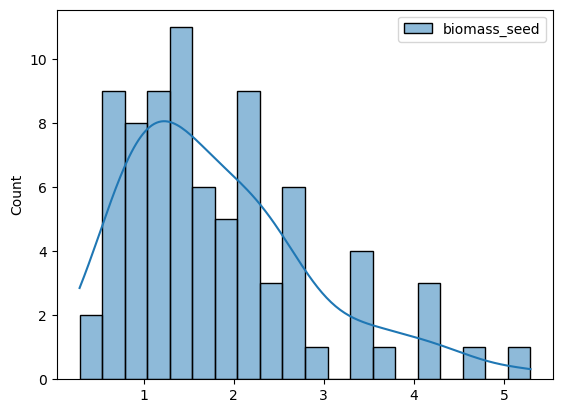

In [48]:
sns.histplot(y_test_exp, bins=20, kde=True)

In [42]:
y_pred = final_model.predict(X_test)
y_pred_exp = np.expm1(y_pred)  # revert log-transform
y_test_exp = np.expm1(y_test)

r2 = r2_score(y_test_exp, y_pred_exp)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.6672
RMSE: 0.6039


In [ ]:
# save X_test.csv and y_test.csv
X_test.to_csv("final_model/X_test.csv", index=False)
y_test.to_csv("final_model/y_test.csv", index=False)

# save X_train.csv and y_train.csv
X_train.to_csv("final_model/X_train.csv", index=False)
y_train.to_csv("final_model/y_train.csv", index=False)

In [43]:
params = final_model.get_params()
print(params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.9556787811383483, 'colsample_bynode': None, 'colsample_bytree': 0.9189038694956897, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.0029143197332355173, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.025092557876503722, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 800, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.00317929504532371, 'reg_lambda': 1.233909528803232, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9681813389671091, 'tree_method': None, 'validate_parameters': None,

In [44]:
import json

params = final_model.get_params()

# Save to JSON file
with open("final_model_params.json", "w") as f:
    json.dump(params, f, indent=4)

In [45]:
final_model.save_model("final_model.bin")

/home/kabs/miniconda3/envs/mulreg/lib/python3.13/site-packages/xgboost/sklearn.py:1028: UserWarning: [11:35:51] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


# Top parameters

In [ ]:


print("R2, RMSE")
print("0.6924, 0.1922: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.016703257751724074, 'subsample': 0.8713936855437243, 'colsample_bytree': 0.8349030049941977, 'gamma': 0.0016348548667503987, 'reg_alpha': 0.3992692335300111, 'reg_lambda': 0.08708803522592554}")
print("0.6920, 0.1924: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.00744796070627547, 'subsample': 0.9857300248305214, 'colsample_bytree': 0.8901834813137577, 'gamma': 0.004209441060405522, 'reg_alpha': 0.00032239816061096875, 'reg_lambda': 0.014587372023012928, 'min_child_weight': 5, 'colsample_bylevel': 0.9077039563046868}")
print("0.6853, 0.1944 {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.08444231679226442, 'subsample': 0.8841235401211052, 'colsample_bytree': 0.7422003085925379, 'gamma': 0.004608805759406017, 'reg_alpha': 0.093538078937408, 'reg_lambda': 0.06123340968233031, 'min_child_weight': 7, 'colsample_bylevel': 0.6639441724866416}")



R2, RMSE
0.6924, 0.1922: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.016703257751724074, 'subsample': 0.8713936855437243, 'colsample_bytree': 0.8349030049941977, 'gamma': 0.0016348548667503987, 'reg_alpha': 0.3992692335300111, 'reg_lambda': 0.08708803522592554}
0.6920, 0.1924: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.00744796070627547, 'subsample': 0.9857300248305214, 'colsample_bytree': 0.8901834813137577, 'gamma': 0.004209441060405522, 'reg_alpha': 0.00032239816061096875, 'reg_lambda': 0.014587372023012928, 'min_child_weight': 5, 'colsample_bylevel': 0.9077039563046868}
0.6853, 0.1944 {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.08444231679226442, 'subsample': 0.8841235401211052, 'colsample_bytree': 0.7422003085925379, 'gamma': 0.004608805759406017, 'reg_alpha': 0.093538078937408, 'reg_lambda': 0.06123340968233031, 'min_child_weight': 7, 'colsample_bylevel': 0.6639441724866416}
